In [1]:
# Replace part of the OUTPUT_PATH to create a new folder 
# for the detection results

OUTPUT_PATH = "Temp/LoanApplications_Offline/"
NEW_OUTPUT_PATH = "Temp/LoanApplications_Offline__DETECTION/"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# My packages
from source import parse_mxml as pm
from source import log_representation as lr
from source import plots as plts
from source import drift_detection as dd
from source import drift_localization as dl
from source import offline_streaming_clustering as off_sc

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed, parallel_backend

import random
random.seed(42)

import os
import glob

import gc
gc.enable()

from scipy.spatial import distance
from sklearn.base import clone as sk_clone 

from copy import deepcopy

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)

In [3]:
def insensitive_glob(pattern):
    def either(c):
        return '[%s%s]' % (c.lower(), c.upper()) if c.isalpha() else c
    return glob.glob(''.join(map(either, pattern)))

def if_any(string, lista):
    # If the string contains any of the values
    # from the list 'lista'
    for l in lista:
        if l in string:
            return True
    return False

In [4]:
# List log files
logs = insensitive_glob(r"../../../../../../../Datasets/Business_Process_Drift_Logs/Logs/*/*k.MXML")
logs = [x.replace('\\', '/') for x in logs if "2.5" not in x]
# logs = [x for x in logs if "2.5" not in x]

In [5]:
# reference objects and map them to strings in dict 
# used in further methods
objects = {
    "model": {
#         "kmeans__k=6": KMeans(n_clusters=6, random_state=42),
#         "kmeans__k=3": KMeans(n_clusters=3, random_state=42),
#         "kmeans__k=2": KMeans(n_clusters=2, random_state=42),
#         "DBSCAN__eps=05ms=5": DBSCAN(eps=0.5, min_samples=5, metric='euclidean'),
#         "DBSCAN__eps=1ms=4": DBSCAN(eps=1, min_samples=4, metric='euclidean'),
#         "DBSCAN__eps=2ms=3": DBSCAN(eps=2, min_samples=3, metric='euclidean'),
        "HDBSCAN__noparams": hdbscan.HDBSCAN(gen_min_span_tree=True, allow_single_cluster=True)
    },
    
    "representation": {
        "activity_binary": lr.get_binary_representation,
        "activity_frequency": lr.get_frequency_representation,
        
        "transitions_binary": lr.get_binary_transitions_representation,
        "transitions_frequency": lr.get_frequency_transitions_representation,
        
        "activity_tfidf": lr.get_tfidf_representation,
        "transitions_tfidf": lr.get_tfidf_transitions_representation,
        
        "activity_transitions_frequency": lr.get_activity_transitions_frequency_representation,
        "activity_transitions_binary": lr.get_activity_transitions_binary_representation
    }
#     "representation": {
#         "activity_binary": lambda x: lr.get_binary_representation(lr.get_traces_as_tokens(x)),
#         "activity_frequency": lambda x: lr.get_frequency_representation(lr.get_traces_as_tokens(x)),
#         "transitions_binary": lambda x: lr.get_binary_transitions_representation(lr.get_traces_as_tokens(x)),
#         "transitions_frequency": lambda x: lr.get_frequency_transitions_representation(lr.get_traces_as_tokens(x)),
#         "activity_transitions_frequency": lambda x: pd.concat([lr.get_frequency_transitions_representation(lr.get_traces_as_tokens(x)), lr.get_frequency_representation(lr.get_traces_as_tokens(x))],axis=1),
#         "activity_transitions_binary": lambda x: pd.concat([lr.get_binary_transitions_representation(lr.get_traces_as_tokens(x)), lr.get_binary_representation(lr.get_traces_as_tokens(x))],axis=1)
#     }
}

In [6]:
# change patterns and they supported representations
activity_binary_drifts = ["cb", "cf", "cm", "fr", "pm", "re", "rp"]
activity_frequency_drifts = activity_binary_drifts + ["cp", "lp"]

transitions_binary_drifts = activity_frequency_drifts + ["cd", "pl", "sw"]
transitions_frequency_drifts = transitions_binary_drifts

activity_tfidf_drifts = transitions_binary_drifts
transitions_tfidf_drifts = transitions_binary_drifts

activity_transitions_frequency_drifts = transitions_binary_drifts
activity_transitions_binary_drifts = transitions_binary_drifts

### Pipeline Offline Clustering

In [7]:
def read_file_and_run_clustering_pipeline(args, return_result=False):
    """
    Read an event log file, represent it into a feature vector space and
    run the trace clustering method over windows. This method outputs results
    as gzip csv files into the "OUTPUT_PATH" folder, or return the result 
    as DataFrame when return_result = True.
    
    Parameters:
    -----------
        args (dict): Dictionary with the parameters and the log_file path
            requiring the following keys:
                example = {
                    'log': <PATH TO LOG_FILE>,
                    'representation': <KEY TO REPRESENTATIONS IN 'objects'>,
                    'parameters': [{
                        'model': <KEY TO MODEL IN 'objects'>, 
                        'sliding_window': <WHETHER TO USE SLIDING WINDOW>,
                        'window_size': <SIZE OF TRACE WINDOW TO USE>,
                        'sliding_step': <STEP OF SLIDING WINDOW>
                    }
        return_result (bool): Whether to return the result as DataFrame
            
    """
    
    # Treat file name to structure size and log type
    split = args["log"].split("/")
    
    # Parse change pattern name
    cd_name = split[-2]
    log_name = split[-1][:-5]

    # Parse size of the event_log
    log_size = log_name.replace(cd_name, "").replace("new_", "")
    log_size = int(float(log_size.replace("k", "")) * 1000)
    
    # Set up true drifts indexes
#     y_true = [x for x in range(int(log_size/10), log_size, int(log_size/10))]
    
    try:
        # Read log and apply trace representation technique
        log_read = pm.all_prep(open(args["log"]))
        tokens = lr.get_traces_as_tokens(log_read)
#         df = objects["representation"][args["representation"]](log_read)
        
        for p in args["parameters"]:
            # String to identify results when exporting files
            tipo_mudanca = cd_name.replace("new_", "")
            
            cached_info = "_".join([
                tipo_mudanca,
                str(log_size),
                p["model"],
                args["representation"],
                str(p["window_size"]),
                str(p["sliding_window"])
            ])
            
#             print(cached_info)
            
            # If already exists, return if needed
            file_to_export = OUTPUT_PATH + tipo_mudanca + '/' + cached_info + '.pickle.gzip'
            if os.path.exists(file_to_export):
                if return_result:
                    r_ = pd.read_pickle(
                        file_to_export,
                        compression='gzip'
                    )
                    return r_
                else:
                    continue
            
            # If file does not exists, run trace clustering step and export file
            all_metrics = off_sc.run_offline_clustering_window(
                tokens,
                objects["representation"][args["representation"]],
                sk_clone(objects["model"][p["model"]]),
                p["window_size"],
#                 df,
                p["sliding_window"],
                sliding_step=p['sliding_step']
            )
            
            # Set up true drifts indexes and append
            y_true = list(range(int(len(tokens)/10), len(tokens), int(len(tokens)/10)))
            all_metrics["y_true"] = all_metrics.apply(lambda x: y_true, axis = 1)
            
            if return_result:
                return all_metrics
            else:
                try:
                    os.makedirs(OUTPUT_PATH + tipo_mudanca + '/')
                except:
                    pass
                all_metrics.to_pickle(file_to_export, compression="gzip")

            gc.collect()
    except Exception as e:
        raise e

#### Run pipeline for specific case(s)

In [10]:
# read_file_and_run_clustering_pipeline({
#     'log': logs[0],
#     'representation': 'activity_binary',
#     'parameters': [{
#         'model': 'HDBSCAN__noparams', 
#         'sliding_window': False,
#         'window_size': 75,
#         'sliding_step': 1
#     }]
# }, return_result=True)

### Run Experiments with several parameters combinations

In [11]:
# Trace clustering parameters
grid_parameters = list(ParameterGrid({
    "sliding_window": [False],    
    "window_size": [100, 125, 150, 200],
    'sliding_step': [1],
    "model": [
#         'kmeans__k=6',
#         'kmeans__k=3',
#         'kmeans__k=2',
#         "DBSCAN__eps=05ms=5",
#         "DBSCAN__eps=1ms=4",
#         "DBSCAN__eps=2ms=3",
        "HDBSCAN__noparams"
    ] 
}))

# Trace vector representations
grid_logs = list(ParameterGrid([
    { "log": [x for x in logs if if_any(x, activity_binary_drifts)],
        "representation": ["activity_binary"]},
    {"log": [x for x in logs if if_any(x, activity_frequency_drifts)],
        "representation": ["activity_frequency"]},
    
    { "log": [x for x in logs if if_any(x, transitions_binary_drifts)],
        "representation": ["transitions_binary"]},
    
    { "log": [x for x in logs if if_any(x, transitions_frequency_drifts)],
        "representation": ["transitions_frequency"]},
    
    { "log": [x for x in logs if if_any(x, activity_tfidf_drifts)],
        "representation": ["activity_tfidf"]},
    {"log": [x for x in logs if if_any(x, transitions_tfidf_drifts)],
        "representation": ["activity_transitions_binary"]},
    
    {"log": [x for x in logs if if_any(x, activity_transitions_frequency_drifts)],
        "representation": ["activity_transitions_frequency"]},
    {"log": [x for x in logs if if_any(x, activity_transitions_binary_drifts)],
        "representation": ["activity_transitions_binary"]}
]))

# Combining all parameters
combs = []
for x in grid_logs:
    dic = x.copy()
    dic['parameters'] = grid_parameters
    
    combs.append(dic)

len(combs), len(grid_parameters), len(combs) * len(grid_parameters) 

(264, 4, 1056)

#### Run parallely

In [12]:
final_resp = Parallel(n_jobs=-1)(
    delayed(read_file_and_run_clustering_pipeline)(comb) for comb in tqdm_notebook(combs)
)
gc.collect()

### Detection Pipeline

In [14]:
# Drift detection parameters
drift_config = list(ParameterGrid([
    {
        "rolling_window": [3]#[3, 4, 5]
        ,"std_tolerance": [3]#[1.25, 1.5, 1.75, 2]
        ,'min_tol': [0.025]#[0.01, 0.007, 0.005, 0.003] 
    }
]))
print(len(drift_config))

1

In [15]:
# List all files obtained after the trace clustering pipeline

clusterizacoes = glob.glob(OUTPUT_PATH + "*/*.pickle.gzip")
print(len(clusterizacoes))

912


In [17]:
# Combinations to run

combs_deteccao = []
for log in clusterizacoes:
    combs_deteccao.append({
        'input': log,
        'combinations': drift_config
    })
print(len(combs_deteccao))

912


In [19]:
def drift_detect_pipeline(args, return_results=False):
    """
        Runs the drift detection method based on the output from the trace
        clustering pipeline for different combination of parameters and every
        feature from tracking the trace clustering evolution. The
        outputs are into a new folder named by the NEW_OUTPUT_PATH variable in 
        gzip csv files.
        
        Parameters:
        -----------
            args (dict): Dictionary with the parameters and the log_file path
                requiring the following keys:
                    example = {
                    }
    """
    # Read file
    all_metrics = pd.read_pickle(args["input"], compression='gzip')
    
    # Parse information from file name
    path_file = args["input"].replace(".pickle.gzip", "").split('\\')
    args.update({
        "tipo_mudanca": path_file[-1].split('_')[0],
        "log_size": int(path_file[-1].split('_')[1]),
        "model": "_".join(path_file[-1].split('_')[2:5]),
        "representation": "_".join(path_file[-1].split('_')[5:-2]),
        "window_size": path_file[-1].split('_')[-2],
        "sliding_window": path_file[-1].split('_')[-1]
    })
    
    # Run detection for every combination of parameter    
    for combination in args['combinations']:
        c = deepcopy(combination)
        c.update({
            'input': args['input'],
            'tipo_mudanca': args['tipo_mudanca'],
            'log_size': args['log_size'],
            'model': args['model'],
            'representation': args['representation'],
            'window_size': args['window_size'],
            'sliding_window': args['sliding_window']
        })
        
        if return_results:
            return __drift_detect_pipeline(
                all_metrics, c, return_results
            )
        else:
            __drift_detect_pipeline(
                all_metrics, c, return_results
            )
    

def __drift_detect_pipeline(all_metrics, args, return_results=False):     
    base_name = args["input"].replace(".pickle.gzip", "")
    base_name = base_name.replace(OUTPUT_PATH, NEW_OUTPUT_PATH)
    
    # Create string with parameters to identify file
    to_string = [
        str(args["rolling_window"]),
        str(args["std_tolerance"]).replace(".", "-"), 
        str(args["min_tol"]).replace(".", "-")
    ]
    
    try:
        os.makedirs(base_name)
    except:
        pass
    
#     final_name = base_name.replace("\\", "/") + "/" + "_".join(to_string) + ".pickle.gzip"
    final_name = base_name.replace("\\", "/") + "_".join(to_string) + ".pickle.gzip"
    
    if os.path.isfile(final_name):
        if return_results:
            return pd.read_pickle(final_name, compression='gzip')
        else:
            print("Already exists")
            return
    
#     y_true = [x for x in range(int(args['log_size']/10), args['log_size'], int(args['log_size']/10))]
    
    # Runs the drift detection for every feature
    results = []
    for col in all_metrics.select_dtypes(include=np.number).columns:
        if (col not in ["i","test_id"]):
#         if (col not in ["k"] and not col.startswith("diff") ) or col in ["diff_centroids"]:
            r = deepcopy(args)
            r["measure"] = col

            detected_drifts, not_drifts, info = dd.detect_concept_drift(
                all_metrics, 
                col,
                args["rolling_window"],
                args["std_tolerance"],
                args["min_tol"]
            )    
    
            # Calculate classification metrics
            metrics_results = dd.get_metrics(
                detected_drifts,
                not_drifts,
                all_metrics["y_true"].iloc[0], #y_true,
                int(args["window_size"])
            )

            r.update(args)
            r.update(metrics_results)

            results.append(r)

            gc.collect()
    
    # Export as file
    pd.DataFrame(results).to_pickle(
        final_name,
        compression="gzip"
    )
    
    if return_results:
        return pd.DataFrame(results)
    
    # print(col, len(results))

In [ ]:
# detection_results = drift_detect_pipeline({
#     'input': '../LoanApplications_Offline\\cb\\cb_10000_kmeans__k=2_binary_100_False.pickle.gzip',
#     'combinations': [{
#        'min_tol': 0.01,
#        'rolling_window': 3,
#        'std_tolerance': 1.25
#     }, {
#        'min_tol': 0.02,
#        'rolling_window': 3,
#        'std_tolerance': 1.25
#     }]
# }, return_results=True)

#### Run parallely

In [20]:
final_resp = Parallel(n_jobs=-1)(
    delayed(drift_detect_pipeline)(comb_d) for comb_d in tqdm_notebook(combs_deteccao)
)

## Consolidate Results

In [27]:
models = [
#     'kmeans__k=6',
#     'kmeans__k=3',
#     'kmeans__k=2',
#     "DBSCAN__eps=05_ms=5",
#     "DBSCAN__eps=1_ms=4",
#     "DBSCAN__eps=2_ms=3",
    "HDBSCAN__noparams"
]

# Function to Read results
def consolidate_results(log):
    return pd.read_pickle(log, compression='gzip')

In [28]:
for model in models:
    # List all files obtained after the trace clustering pipeline
    deteccoes = glob.glob(NEW_OUTPUT_PATH + "/*/*"+model+"*/*.pickle.gzip")

    # Call function to read results and then consolidate
    all_results = pd.DataFrame()
    all_results = all_results.append(Parallel(n_jobs=-1)(
        delayed(consolidate_results)(log) for log in tqdm_notebook(deteccoes)
    ))
    
    # Export as file
    all_results.to_pickle(
        'Temp/all_results_'+model,
        compression="gzip"
    )

## See Results

In [32]:
# Import as file
all_results = pd.read_pickle('Temp/all_results_'+models[0], compression='gzip')
print(all_results.shape)

# Group results by all params and get the mean F1 and Delay among all scenarios
# In other words, what combination of params got the best results in all scenarios

params = ["min_tol", "rolling_window", "std_tolerance", "window_size", "measure", "representation"]
scenarios = ["tipo_mudanca", "log_size"]
validation_metrics = ["F1","Delay"]#,"Support","Precision","Recall"]

all_results_grouped = all_results.groupby(params)[validation_metrics].agg(['mean','std'])
all_results_grouped.columns = all_results_grouped.columns.map('_'.join)
# all_results_grouped = all_results_grouped[all_results_grouped['F1_count']>=len(activity_binary_drifts)]
all_results_grouped.sort_values(["F1_mean","Delay_mean"], ascending=[False,True], inplace=True)
all_results_grouped.head(50)

(62016, 21)


F1_mean  \
min_tol rolling_window std_tolerance window_size measure                         representation                             
0.025   3              3             125         std_diff_centroids              activity_transitions_binary     0.772549   
                                                 diff_centroids                  transitions_binary              0.741352   
                                                                                 activity_frequency              0.737702   
                                                                                 transitions_frequency           0.724667   
                                                                                 activity_transitions_frequency  0.723675   
                                                 std_diff_centroids              transitions_binary              0.716014   
                                     200         diff_centroids                  transitions_binary              0.712830   
                                     125         avg_skewness                    activity_transitions_binary     0.710393   
                                                 diff_centroids                  activity_transitions_binary     0.695746   
                                     200         diff_centroids                  transitions_frequency           0.693489   
                                     125         std_diff_centroids              activity_transitions_frequency  0.682808   
                                                 n_representation_distinct       activity_transitions_frequency  0.678082   
                                                                                 transitions_frequency           0.678082   
                                                 n_variants                      activity_tfidf                  0.674996   
                                                                                 activity_transitions_binary     0.674996   
                                                                                 activity_transitions_frequency  0.674996   
                                                                                 transitions_binary              0.674996   
                                                                                 transitions_frequency           0.674996   
                                                 n_representation_distinct       activity_transitions_binary     0.674225   
                                                                                 transitions_binary              0.674225   
                                                 std_skewness                    transitions_binary              0.671333   
                                     200         diff_centroids                  activity_binary                 0.670347   
                                                                                 activity_transitions_binary     0.669958   
                                                                                 activity_transitions_frequency  0.668709   
                                     150         inter_dist_cosine_std           activity_transitions_binary     0.667299   
                                     200         diff_centroids                  activity_frequency              0.666158   
                                     150         n_representation_distinct       activity_transitions_binary     0.665837   
                                                                                 transitions_binary              0.665837   
                                     125         diff_centroids                  activity_binary                 0.665541   
                                     200         inter_dist_cosine_std           activity_binary                 0.663925   
                                                 std_skewness                    activity_binary                 0

In [40]:
best_results_by_representation = all_results_grouped.reset_index().groupby("representation").first().reset_index().sort_values(["F1_mean","Delay_mean"], ascending=[False,True])
best_results_by_representation

,representation,min_tol,rolling_window,std_tolerance,window_size,measure,F1_mean,F1_std,Delay_mean,Delay_std
3,activity_transitions_binary,0.025,3,3,125,std_diff_centroids,0.772549,0.184428,0.930688,0.233455
5,transitions_binary,0.025,3,3,125,diff_centroids,0.741352,0.196075,0.908719,0.270022
1,activity_frequency,0.025,3,3,125,diff_centroids,0.737702,0.182625,0.941784,0.201496
6,transitions_frequency,0.025,3,3,125,diff_centroids,0.724667,0.216285,0.904200,0.278015
4,activity_transitions_frequency,0.025,3,3,125,diff_centroids,0.723675,0.185639,0.935152,0.270984
2,activity_tfidf,0.025,3,3,125,n_variants,0.674996,0.198696,0.920161,0.288185
0,activity_binary,0.025,3,3,200,diff_centroids,0.670347,0.242997,0.982993,0.338428


In [36]:
best_result = pd.merge(left=all_results
            , right=best_results_by_representation
            , how='inner', on=params)
results_table = best_result.pivot_table(values=["F1","Delay"]
                                        , index=["tipo_mudanca"]
                                        , columns=["representation"]
                                        , aggfunc='mean')\
                                    .sort_index(axis='columns',level=[1,0], ascending=[True,False])
results_table

,F1,Delay,F1,Delay,F1,Delay,F1,Delay,F1,Delay,F1,Delay,F1,Delay
representation,activity_binary,activity_binary,activity_frequency,activity_frequency,activity_tfidf,activity_tfidf,activity_transitions_binary,activity_transitions_binary,activity_transitions_frequency,activity_transitions_frequency,transitions_binary,transitions_binary,transitions_frequency,transitions_frequency
tipo_mudanca,,,,,,,,,,,,,,
cb,0.456044,1.183333,0.650439,1.122222,0.757895,0.829630,0.641211,0.888889,0.545285,0.800000,0.634174,1.122222,0.741186,0.970370
cd,NaN,NaN,NaN,NaN,0.810185,0.757937,0.830688,1.225397,0.699353,1.130952,0.757143,0.998677,0.677249,0.608333
cf,0.788462,0.754630,0.805986,0.962963,0.833333,0.904762,0.840789,0.804233,0.772985,0.882937,0.832244,0.750000,0.780392,0.805556
cm,0.625000,1.212963,0.769063,0.952381,0.703130,0.707937,0.787281,0.888889,0.701961,1.055556,0.744281,0.885714,0.749020,1.000000
cp,NaN,NaN,0.777778,0.944444,0.569561,1.050000,0.839035,0.964286,0.780702,0.833333,0.763402,0.850000,0.754386,0.851852
fr,0.455556,0.763889,0.538105,0.952381,0.574325,1.166667,0.631536,1.047619,0.541558,0.816667,0.458995,0.850000,0.605994,1.066667
lp,NaN,NaN,0.762963,1.055556,0.825397,1.000000,0.555807,1.066667,0.798489,1.047619,0.754202,0.958333,0.692437,0.833333
pl,NaN,NaN,NaN,NaN,0.896296,0.791667,0.873677,0.996693,0.687208,1.087302,0.839035,1.452381,0.793350,1.470238


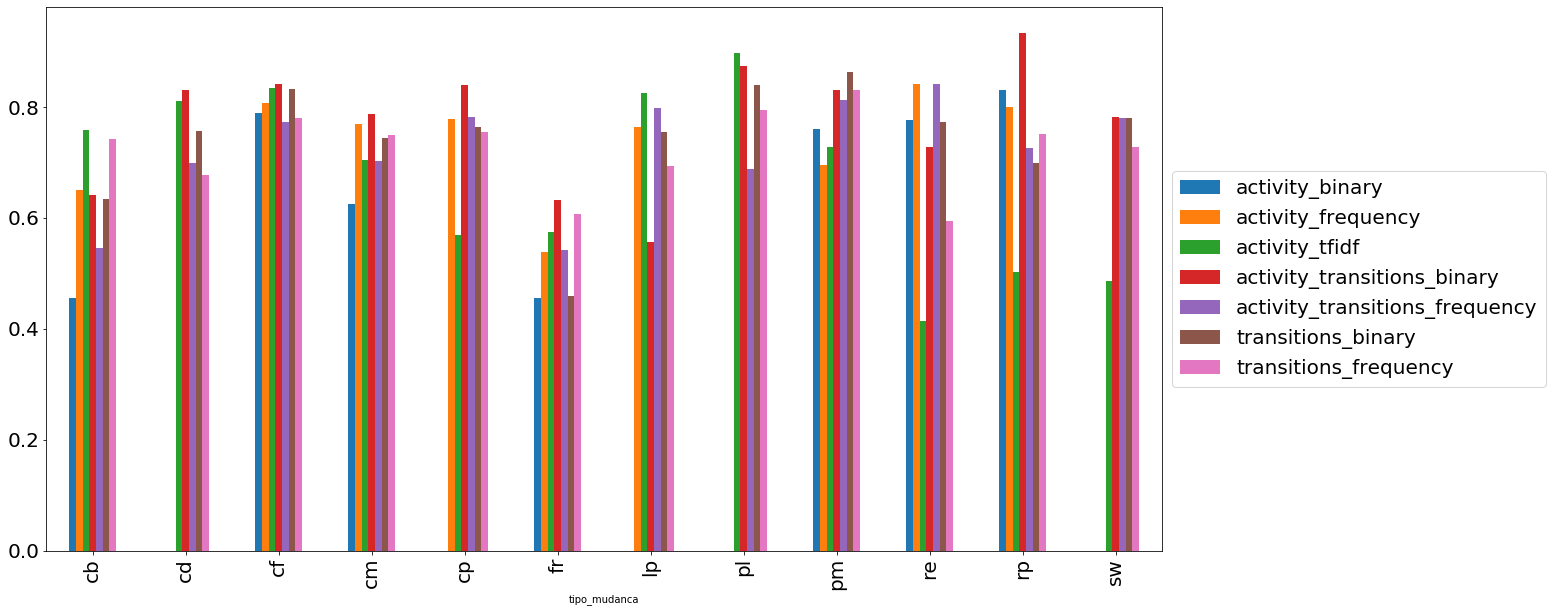

In [41]:
results_table['F1'].plot(kind='bar', figsize=(20,10), fontsize=20)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=20)
plt.show()

In [43]:
results_table_logsize = best_result.pivot_table(values=["F1"]#,"Delay"]
                                                , index=["tipo_mudanca"]
                                                , columns=["representation"
                                                , "log_size"]
                                                , aggfunc='mean')\
                                    .sort_index(axis='columns',level=[1,0], ascending=[True,False])
results_table_logsize

F1                                         \
representation activity_binary                     activity_frequency   
log_size                 5000      7500      10000              5000    
tipo_mudanca                                                            
cb                    0.500000  0.153846  0.714286           0.800000   
cd                         NaN       NaN       NaN                NaN   
cf                    0.615385  0.750000  1.000000           1.000000   
cm                    0.500000  0.375000  1.000000           0.941176   
cp                         NaN       NaN       NaN           1.000000   
fr                    0.500000  0.333333  0.533333           0.461538   
lp                         NaN       NaN       NaN           0.800000   
pl                         NaN       NaN       NaN                NaN   
pm                    0.615385  0.666667  1.000000           0.714286   
re                    0.615385  0.714286  1.000000           1.000000   
rp                    0.615385  0.875000  1.000000           1.000000   
sw                         NaN       NaN       NaN                NaN   

                                                                       \
representation                     activity_tfidf                       
log_size           7500      10000          5000      7500      10000   
tipo_mudanca                                                            
cb              0.625000  0.526316       0.800000  0.947368  0.526316   
cd                   NaN       NaN       0.875000  0.888889  0.666667   
cf              0.470588  0.947368       0.800000  1.000000  0.700000   
cm              0.588235  0.777778       0.666667  0.736842  0.705882   
cp              0.666667  0.666667       0.571429  0.666667  0.470588   
fr              0.375000  0.777778       0.461538  0.705882  0.555556   
lp              0.888889  0.600000       1.000000  1.000000  0.476190   
pl                   NaN       NaN       1.000000  0.888889  0.800000   
pm              0.705882  0.666667       0.666667  0.625000  0.888889   
re              0.888889  0.631579       0.333333  0.533333  0.375000   
rp              0.555556  0.842105       0.363636  0.588235  0.555556   
sw                   NaN       NaN       0.615385  0.400000  0.444444   

                                                                \
representation activity_transitions_binary                       
log_size                             5000      7500      10000   
tipo_mudanca                                                     
cb                                0.666667  0.941176  0.315789   
cd                                0.714286  1.000000  0.777778   
cf                                0.875000  0.947368  0.700000   
cm                                0.875000  0.750000  0.736842   
cp                                0.875000  0.842105  0.800000   
fr                                0.875000  0.666667  0.352941   
lp                                0.461538  0.705882  0.500000   
pl                                0.875000  0.888889  0.857143   
pm                                0.875000  0.947368  0.666667   
re                                1.000000  0.625000  0.555556   
rp                                1.000000  1.000000  0.800000   
sw                                1.000000  0.842105  0.500000   

                                                                   \
representation activity_transitions_frequency                       
log_size                                5000      7500      10000   
tipo_mudanca                                                        
cb                                   0.714286  0.588235  0.333333   
cd                                   0.875000  0.842105  0.380952   
cf                                   0.941176  0.777778  0.600000   
cm                                   0.800000  0.705882  0.600000   
cp                                   1.000000  0.842105  0.500000   
fr          

In [55]:
shsow_result = pd.merge(left=best_result
            , right=best_results_by_representation.head(1)
            , how='inner', on=params)
shsow_result

,min_tol,rolling_window,std_tolerance,input,tipo_mudanca,log_size,model,representation,window_size,sliding_window,measure,Precision,Recall,F1,Delay,Correct_Predictions,Support_correct,Support,Not_Drifts_Found,Drifts_Found,Resp,F1_mean_x,F1_std_x,Delay_mean_x,Delay_std_x,F1_mean_y,F1_std_y,Delay_mean_y,Delay_std_y
0,0.025,3,3,Temp/LoanApplications_Offline\cb\cb_10000_HDBSCAN__noparams_activity_transitions_binary_125_Fals...,cb,10000,HDBSCAN__noparams,activity_transitions_binary,125,False,std_diff_centroids,0.300000,0.333333,0.315789,0.666667,"[0, 0, 1, 0, 1, 0, 1, 0, 0]",3,48,"[625, 750, 875, 1000, 1125, 1250, 1375, 2000, 2125, 2250, 2375, 2500, 2625, 2750, 2875, 3000, 36...","[1500, 3125, 3750, 5125, 6375, 7000, 7750, 8750, 9375, 9875]","[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]",0.772549,0.184428,0.930688,0.233455,0.772549,0.184428,0.930688,0.233455
1,0.025,3,3,Temp/LoanApplications_Offline\cb\cb_5000_HDBSCAN__noparams_activity_transitions_binary_125_False...,cb,5000,HDBSCAN__noparams,activity_transitions_binary,125,False,std_diff_centroids,0.833333,0.555556,0.666667,1.000000,"[1, 0, 1, 0, 1, 0, 0, 1, 1]",5,18,"[625, 1250, 1375, 1500, 2125, 2250, 2375, 3000, 3125, 3250, 3875, 4000]","[750, 1625, 2500, 3375, 4125, 4625]","[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]",0.772549,0.184428,0.930688,0.233455,0.772549,0.184428,0.930688,0.233455
2,0.025,3,3,Temp/LoanApplications_Offline\cb\cb_7500_HDBSCAN__noparams_activity_transitions_binary_125_False...,cb,7500,HDBSCAN__noparams,activity_transitions_binary,125,False,std_diff_centroids,1.000000,0.888889,0.941176,1.000000,"[1, 1, 1, 1, 1, 0, 1, 1, 1]",8,32,"[625, 1250, 1375, 1500, 2125, 2250, 2875, 3000, 3125, 4250, 4375, 4500, 4625, 4750, 4875, 5000, ...","[750, 1625, 2375, 3250, 3750, 5500, 6125, 6875]","[750, 1500, 2250, 3000, 3750, 4500, 5250, 6000, 6750]",0.772549,0.184428,0.930688,0.233455,0.772549,0.184428,0.930688,0.233455
3,0.025,3,3,Temp/LoanApplications_Offline\cd\cd_10000_HDBSCAN__noparams_activity_transitions_binary_125_Fals...,cd,10000,HDBSCAN__noparams,activity_transitions_binary,125,False,std_diff_centroids,0.777778,0.777778,0.777778,1.142857,"[1, 1, 1, 1, 1, 0, 1, 1, 0]",7,50,"[625, 750, 875, 1000, 1125, 1750, 1875, 2000, 2625, 2750, 2875, 3000, 3625, 3750, 3875, 4000, 46...","[1250, 2125, 3125, 4125, 5250, 7000, 8125, 8750, 9750]","[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]",0.772549,0.184428,0.930688,0.233455,0.772549,0.184428,0.930688,0.233455
4,0.025,3,3,Temp/LoanApplications_Offline\cd\cd_5000_HDBSCAN__noparams_activity_transitions_binary_125_False...,cd,5000,HDBSCAN__noparams,activity_transitions_binary,125,False,std_diff_centroids,1.000000,0.555556,0.714286,1.200000,"[1, 0, 1, 1, 0, 0, 1, 0, 1]",5,21,"[1125, 1250, 1375, 1500, 2625, 2750, 2875, 3000, 3125, 3250, 3375, 3500, 3625, 4250, 4375, 4500]","[625, 1625, 2125, 3750, 4625]","[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]",0.772549,0.184428,0.930688,0.233455,0.772549,0.184428,0.930688,0.233455
5,0.025,3,3,Temp/LoanApplications_Offline\cd\cd_7500_HDBSCAN__noparams_activity_transitions_binary_125_False...,cd,7500,HDBSCAN__noparams,activity_transitions_binary,125,False,std_diff_centroids,1.000000,1.000000,1.000000,1.333333,"[1, 1, 1, 1, 1, 1, 1, 1, 1]",9,29,"[625, 750, 1375, 1500, 1625, 2750, 2875, 3000, 3125, 3750, 4375, 4500, 4625, 5250, 5875, 6000, 6...","[875, 1750, 2250, 3250, 3875, 4750, 5375, 6250, 6875]","[750, 1500, 2250, 3000, 3750, 4500, 5250, 6000, 6750]",0.772549,0.184428,0.930688,0.233455,0.772549,0.184428,0.930688,0.233455
6,0.025,3,3,Temp/LoanApplications_Offline\cf\cf_10000_HDBSCAN__noparams_activity_transitions_binary_125_Fals...,cf,10000,HDBSCAN__noparams,activity_transitions_binary,125,False,std_diff_centroids,0.636364,0.777778,0.700000,0.857143,"[0, 0, 1, 1, 1, 1, 1, 1, 1]",7,44,"[625, 750, 875, 1000, 1125, 1250, 1375, 1500, 1625, 2250, 2375, 2500, 2625, 2750, 2875, 3000, 46...","[1750, 3125, 3625, 4125, 5125, 6000, 7000, 8125, 8750, 9250, 9750]","[

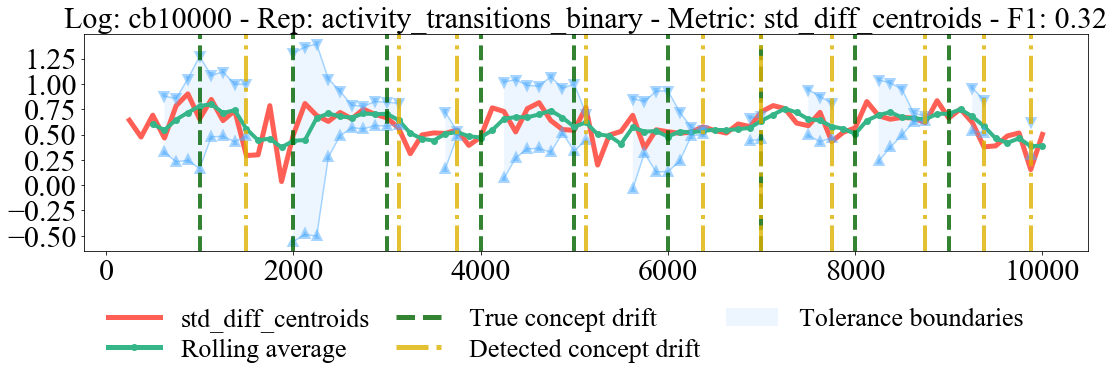

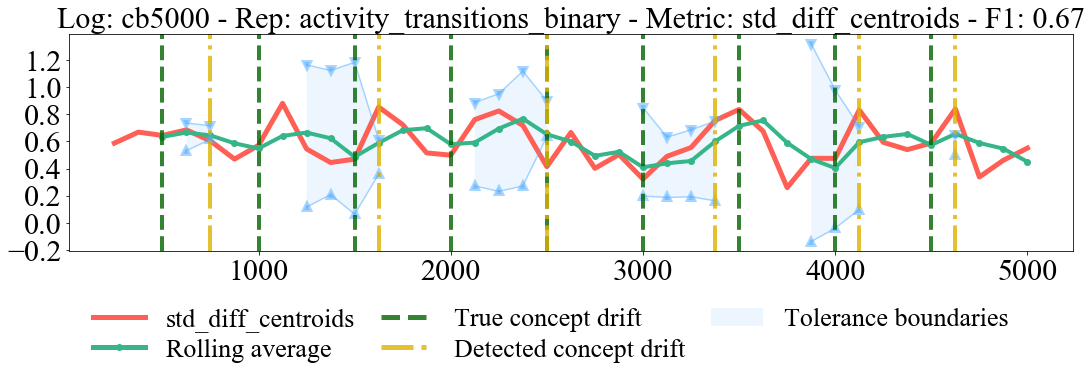

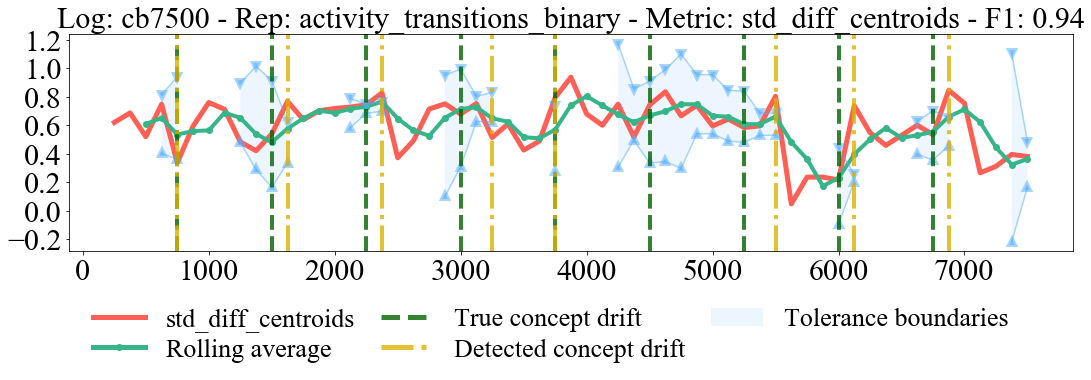

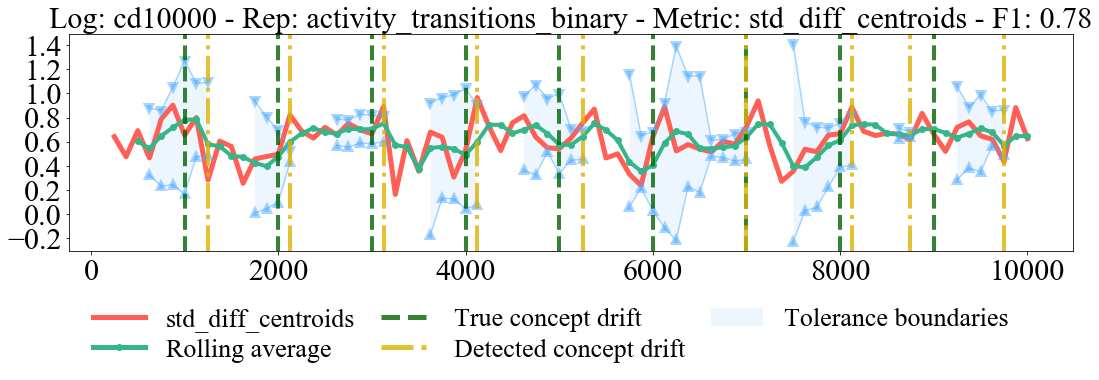

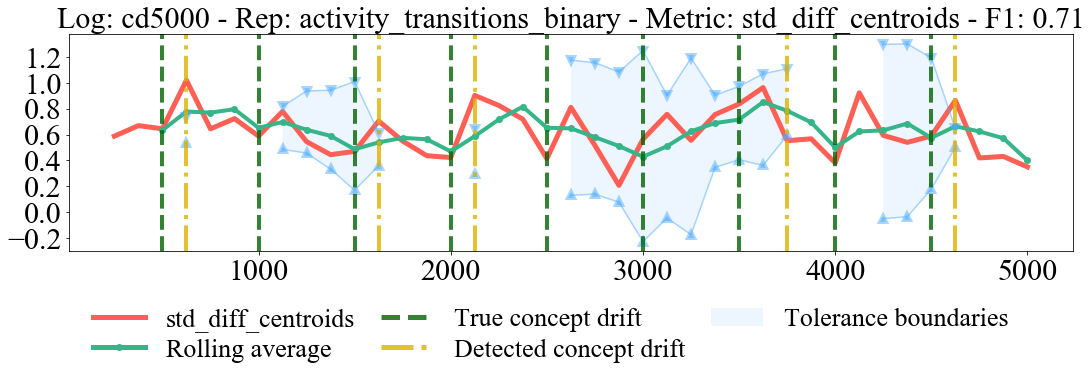

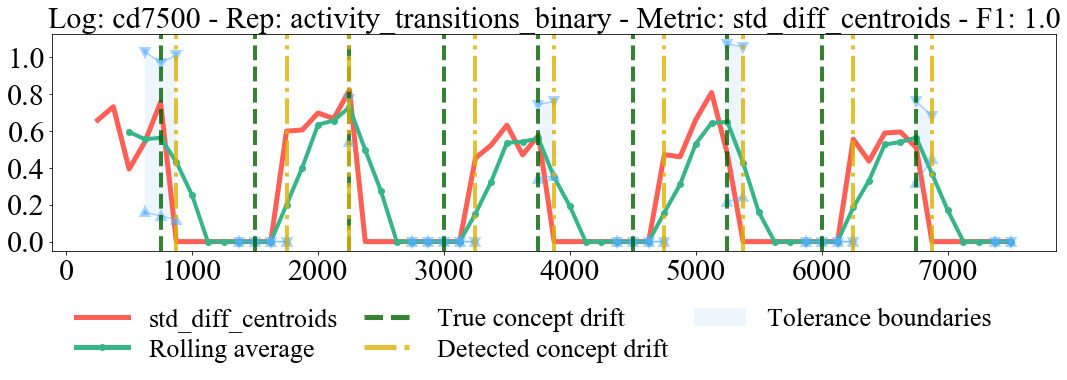

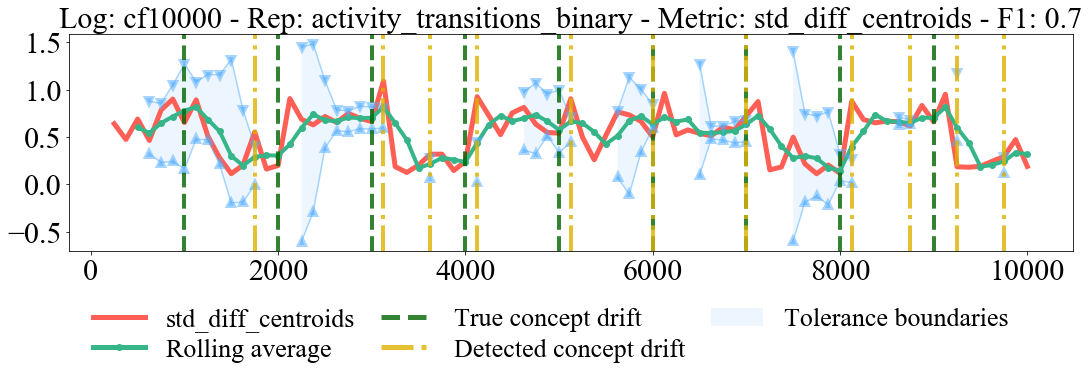

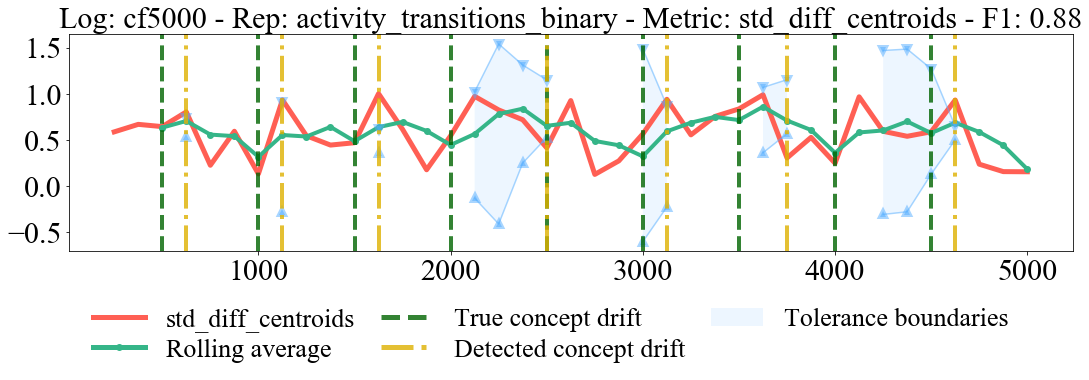

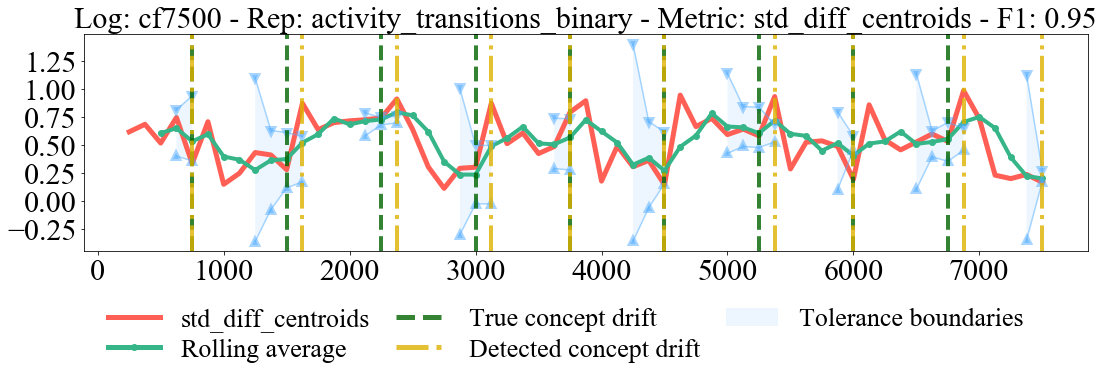

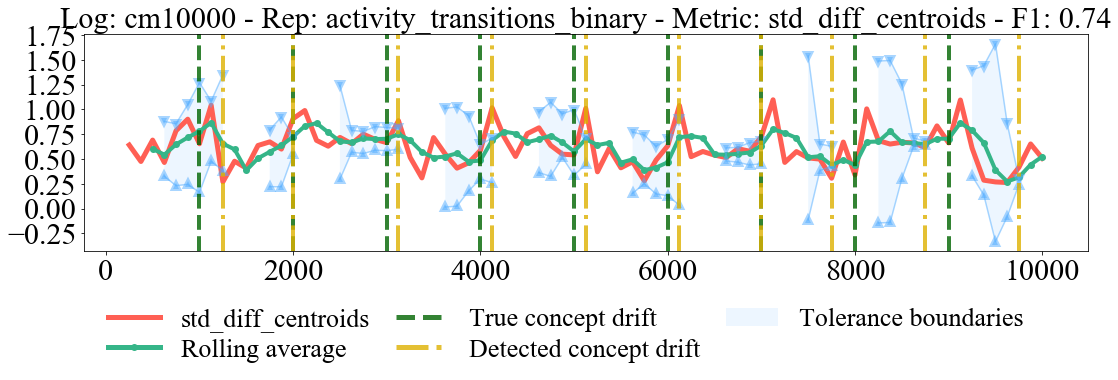

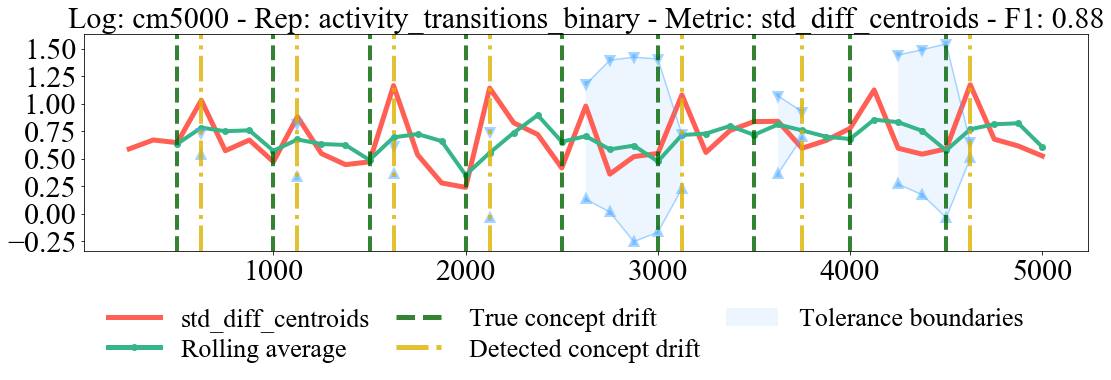

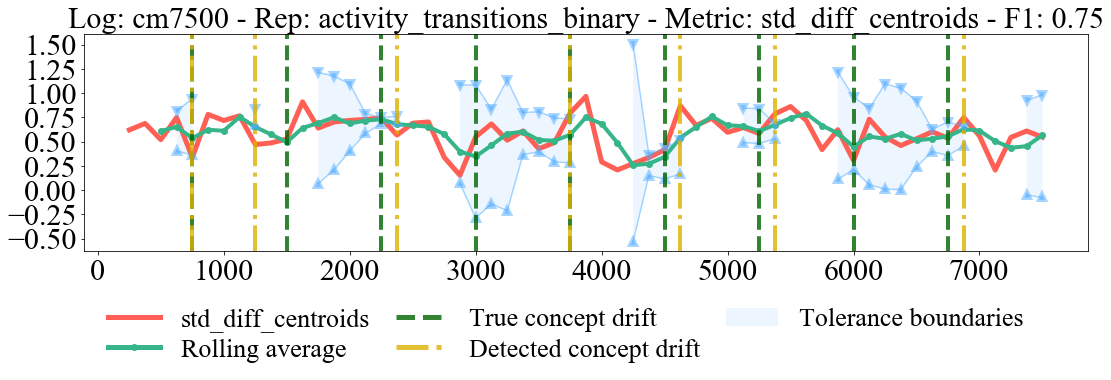

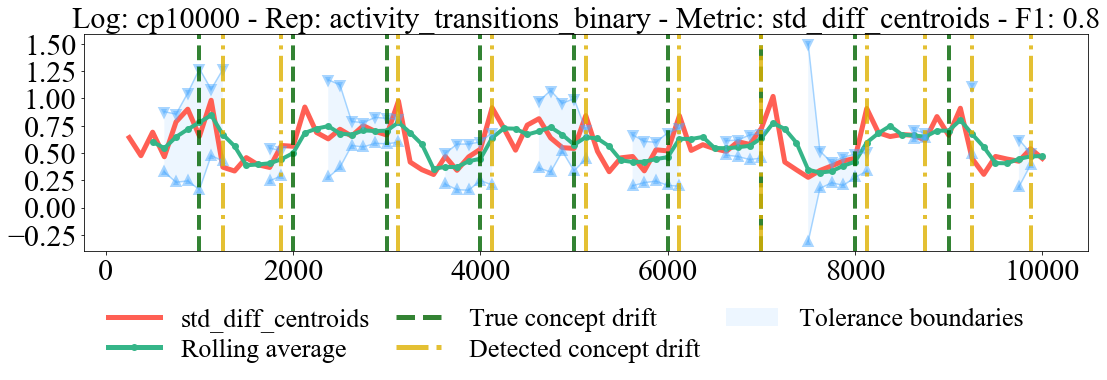

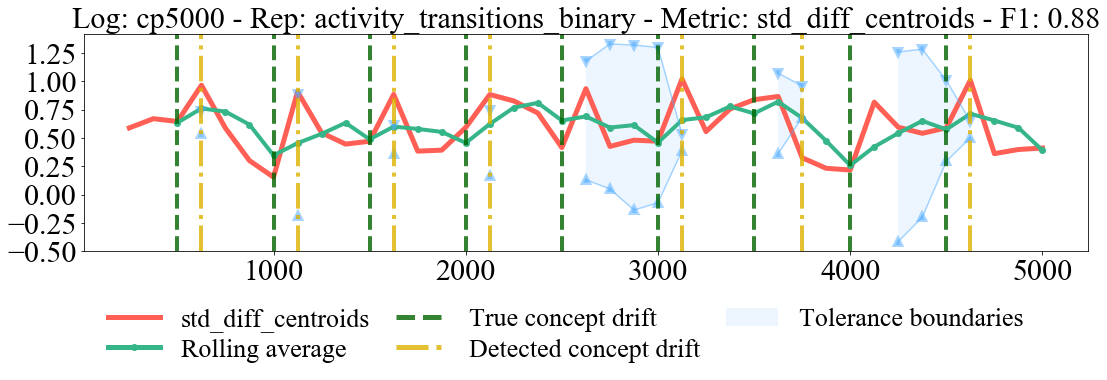

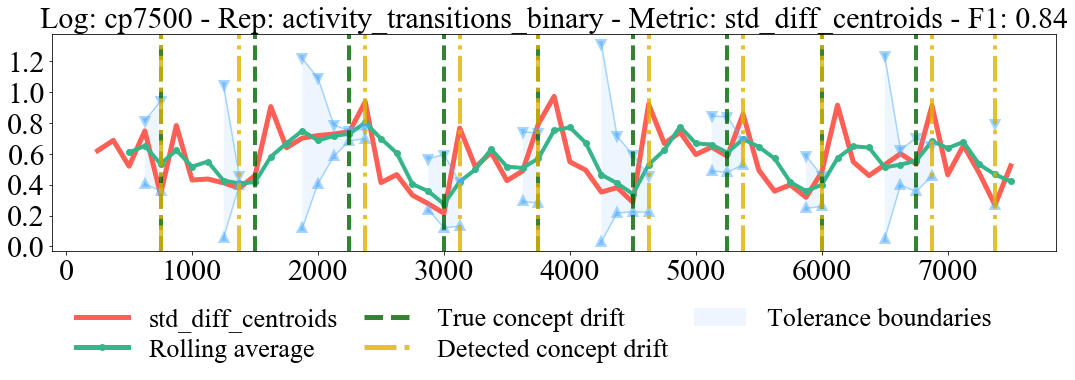

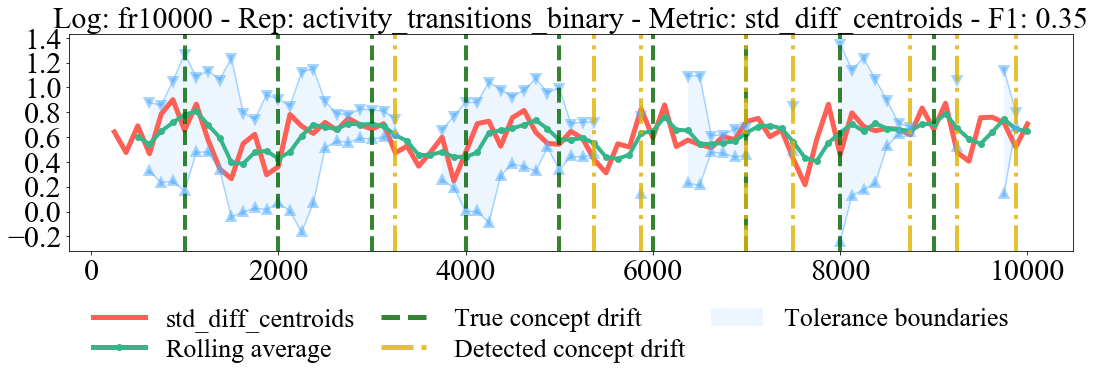

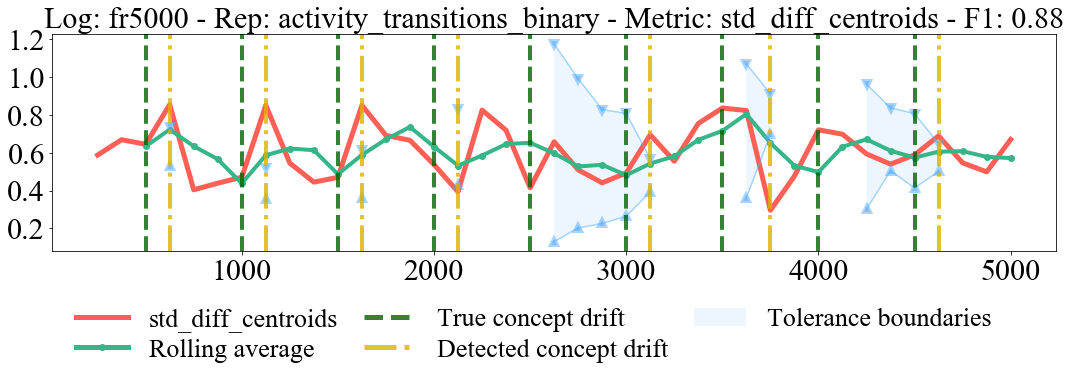

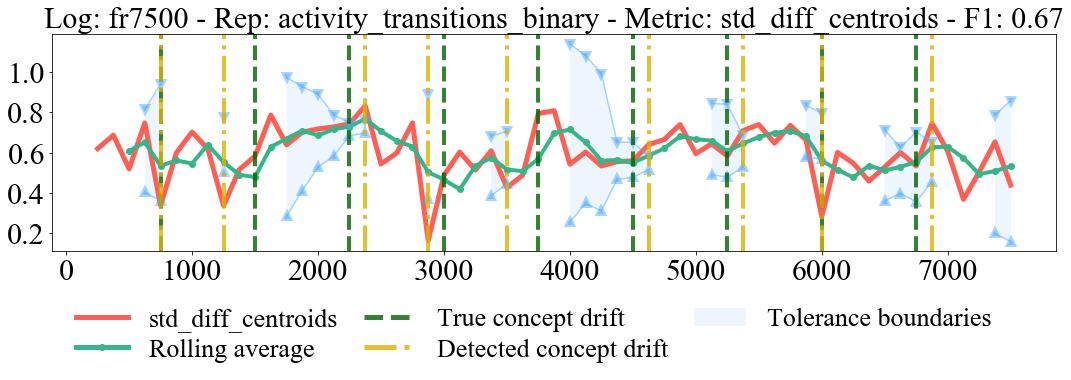

KeyboardInterrupt: 

In [56]:
for row in range(0,len(shsow_result)):

    shsow_result_log = [x for x in logs if shsow_result.iloc[row]["tipo_mudanca"] in x 
         and str(shsow_result.iloc[row]["log_size"]/1000) in 
                    str(float(x.split("/")[-1][:-5].replace("k", "").replace(x.split("/")[-2],"")))]
    
    log_read = pm.all_prep(open(shsow_result_log[0]))
    tokens = lr.get_traces_as_tokens(log_read)

    run_df = off_sc.run_offline_clustering_window(
        tokens,
        objects["representation"][shsow_result.iloc[row]['representation']],
        objects["model"][shsow_result.iloc[row]['model']],
        int(shsow_result.iloc[row]['window_size']),
        sliding_window=False,
        sliding_step=1
    )

    drifts, not_drifts, info = dd.detect_concept_drift(
        run_df,
        shsow_result.iloc[row]['measure'],
        rolling_window=shsow_result.iloc[row]['rolling_window'],
        std_tolerance=shsow_result.iloc[row]['std_tolerance'],
        min_tol=shsow_result.iloc[row]['min_tol']
    )

    plts.plot_deteccao_drift(
        run_df,
        shsow_result.iloc[row]['measure'],
        shsow_result.iloc[row]['Drifts_Found'],
        shsow_result.iloc[row]['Resp'],
        info['means'],
        info['lowers'],
        info['uppers'],
        save_png=""
    )
    plt.title("Log: " + shsow_result.iloc[row]["tipo_mudanca"] + str(shsow_result.iloc[row]["log_size"]) 
                  + " - Rep: " + shsow_result.iloc[row]["representation"] 
                  + " - Metric: " + shsow_result.iloc[row]["measure"]
                  + " - F1: " + str(round(shsow_result.iloc[row]["F1"],2))
              , size=30)
    plt.show()

In [ ]:
# all_results.to_excel('Resultados_PL.xlsx')